Final Portfolio Value: 537472.01


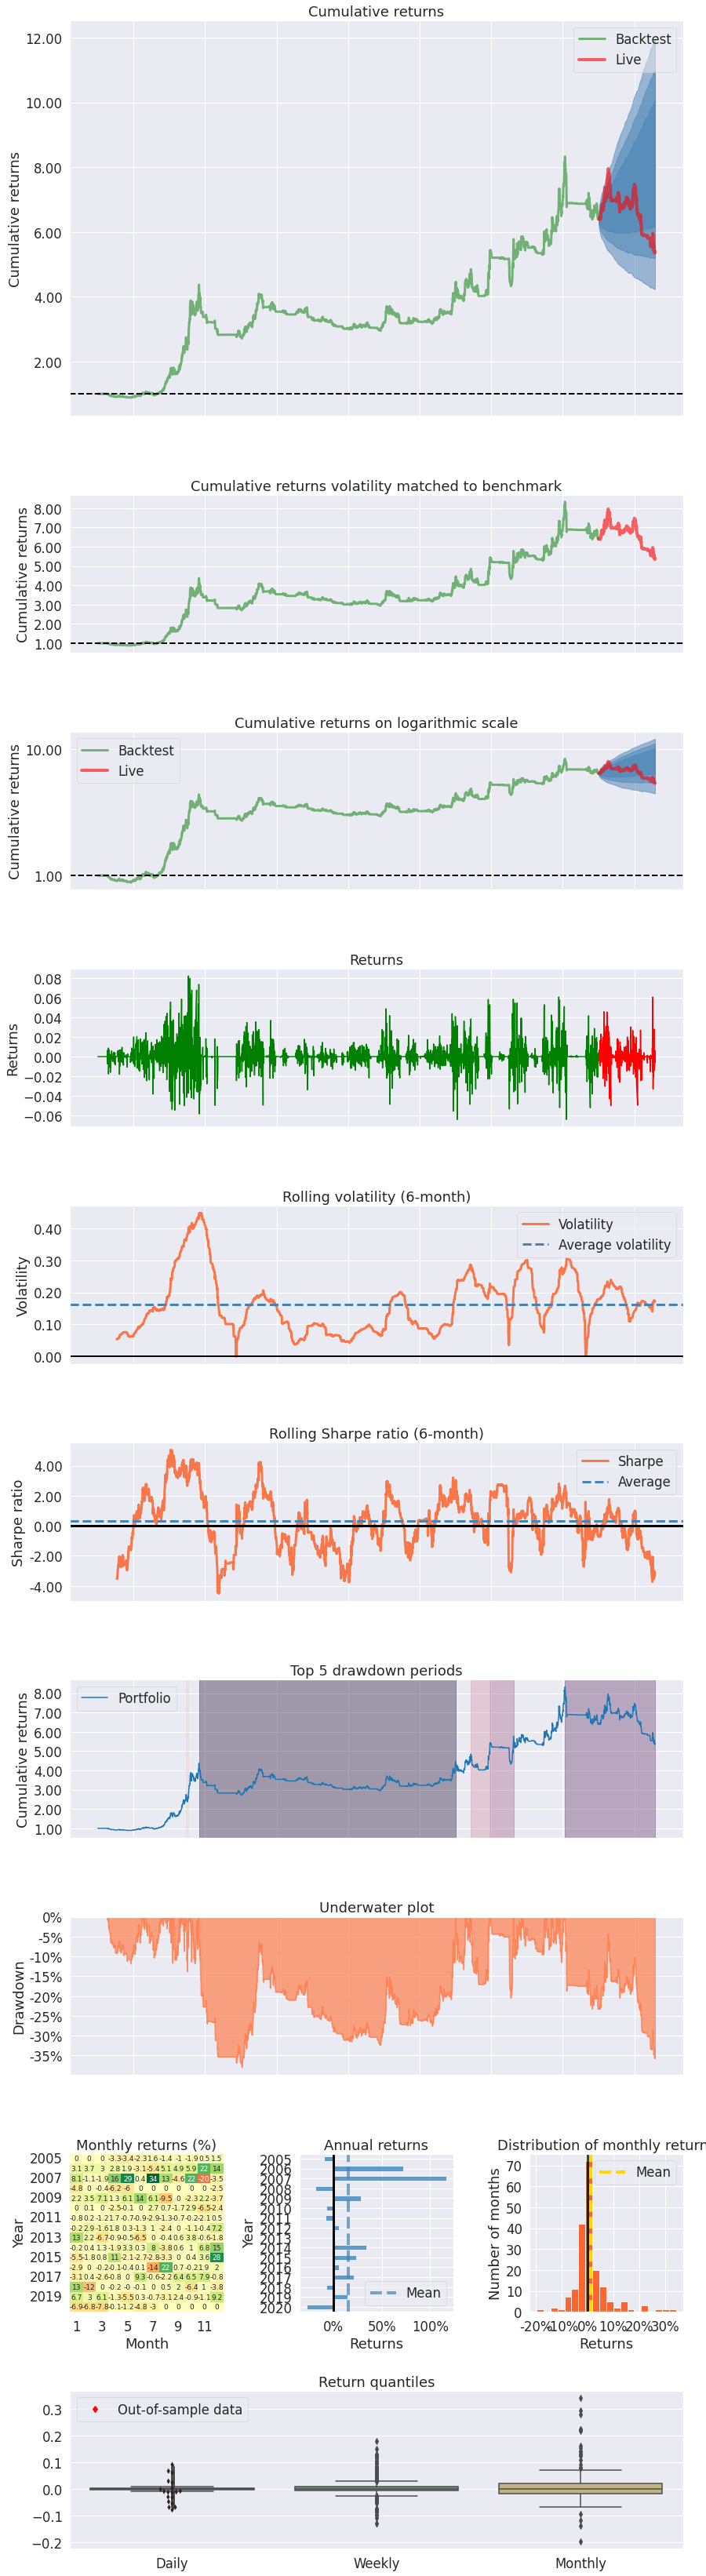

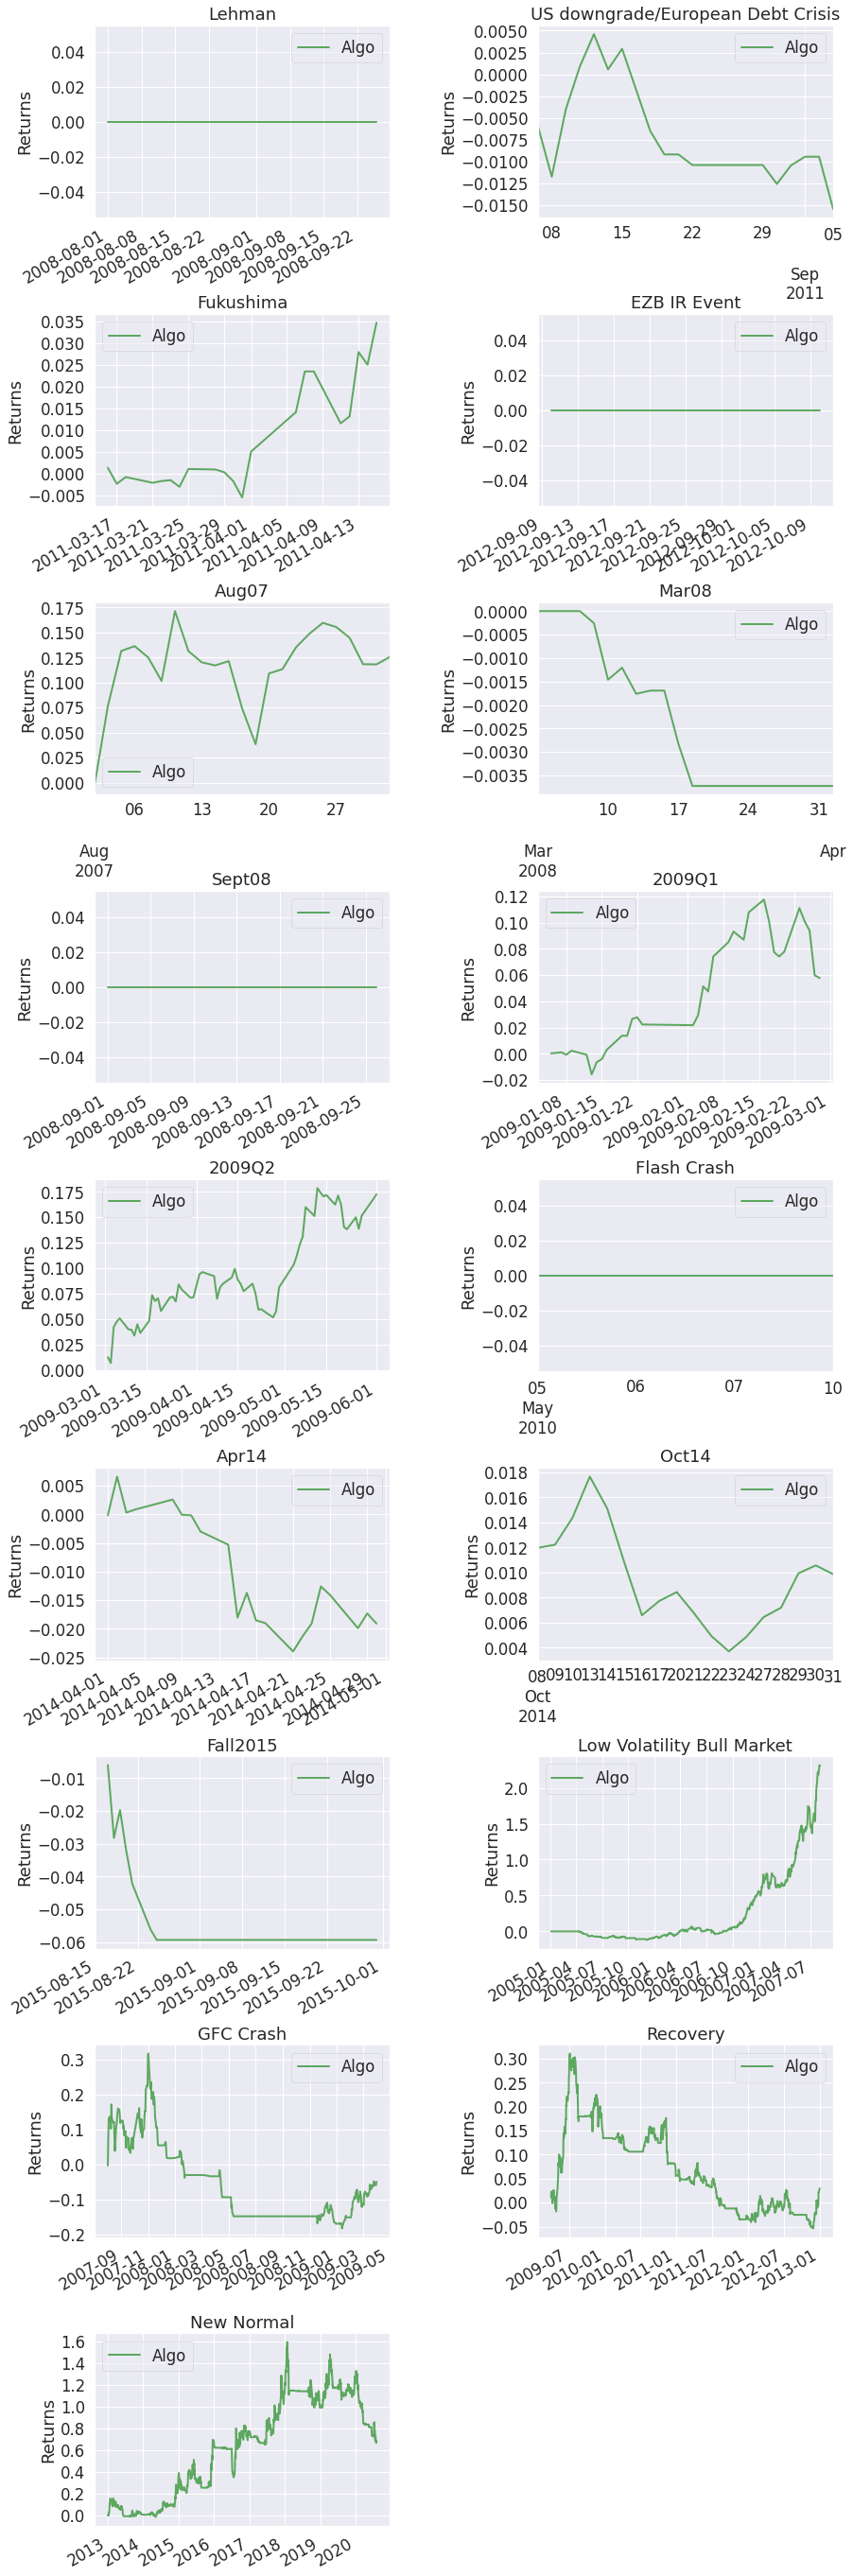

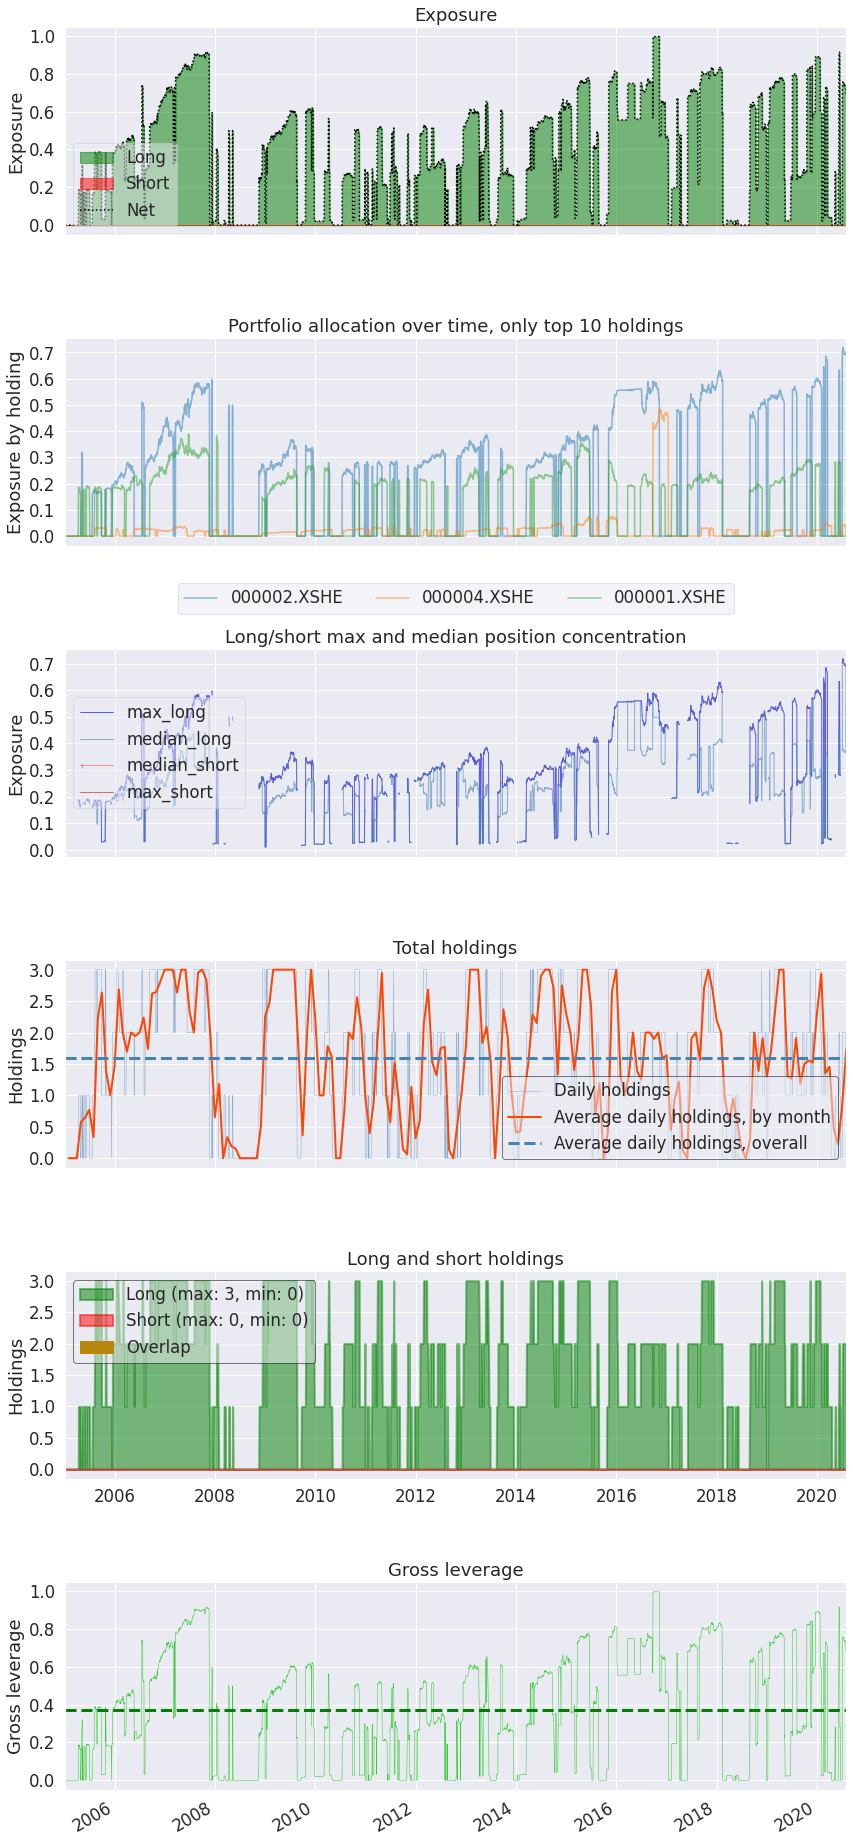

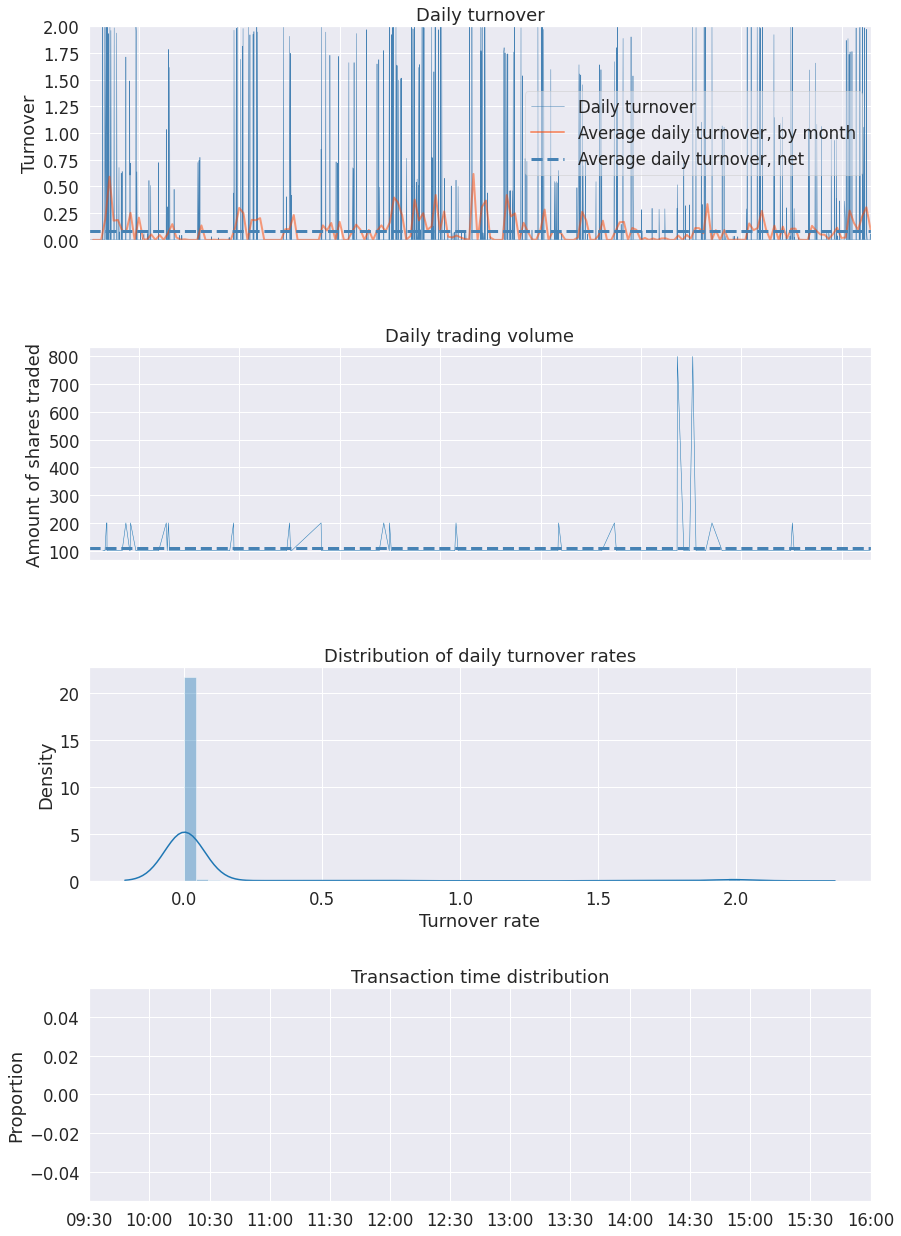

In [2]:
import datetime  
import os.path  
import sys  
import backtesting as bt 
import pandas as pd
import pyfolio as pf
import warnings 
warnings.filterwarnings('ignore')

stk_num = 3  # 回测股票数目
# 创建策略
class SmaCross(bt.Strategy):
    # 可配置策略参数
    params = dict(
        pfast=5,  # 短期均线周期
        pslow=60,   # 长期均线周期
        poneplot = False,  # 是否打印到同一张图
        pstake = 100 # 单笔交易股票数目
    )
    def __init__(self):
        self.log_file = open('position_log.txt', 'w') # 用于输出仓位信息
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()
            self.inds[d]['sma1'] = bt.ind.SMA(d.close, period=self.p.pfast)  # 短期均线
            self.inds[d]['sma2'] = bt.ind.SMA(d.close, period=self.p.pslow)  # 长期均线
            self.inds[d]['cross'] = bt.ind.CrossOver(self.inds[d]['sma1'], self.inds[d]['sma2'], plot = False)  # 交叉信号
            # 跳过第一只股票data，第一只股票data作为主图数据
            if i > 0:
                if self.p.poneplot:
                    d.plotinfo.plotmaster = self.datas[0]
    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name           # 获取时间及股票代码
            pos = self.getposition(d)
            if not len(pos):                                 # 不在场内，则可以买入
                if self.inds[d]['cross'] > 0:                # 如果金叉
                    self.buy(data = d, size = self.p.pstake) # 买买买
            elif self.inds[d]['cross'] < 0:                  # 在场内，且死叉
                self.close(data = d)                         # 卖卖卖

        # 打印仓位信息
        print('*****************************************************************************', file = self.log_file)
        print(self.data.datetime.date(), file = self.log_file)
        for i, d in enumerate(self.datas):
            pos = self.getposition(d)
            if len(pos):
                print('{}, 持仓:{}, 成本价:{}, 当前价:{}, 盈亏:{:.2f}'.format(
                    d._name, pos.size, pos.price, pos.adjbase, pos.size * (pos.adjbase - pos.price)),
                     file = self.log_file)

    def stop(self):
        self.log_file.close()
        pass

cerebro = bt.Cerebro()  # 创建cerebro

data_root = './stock/day/'
file_list =sorted(os.listdir(data_root))
# 读入股票代码
for i in range(stk_num):
    # 读入数据
    datapath = data_root + file_list[i]
    # 创建价格数据
    data = bt.feeds.GenericCSVData(
            dataname = datapath,
            fromdate = datetime.datetime(2005,1,4),
            todate = datetime.datetime(2020, 7, 31),
            nullvalue = 0.0,
            dtformat = ('%Y-%m-%d'),
            datetime = 0,
            open = 1,
            high = 2,
            low = 3,
            close = 4,
            volume = 5,
            openinterest = -1
            )
    # 在Cerebro中添加股票数据
    cerebro.adddata(data, name = file_list[i][:-4])
# 设置启动资金
cerebro.broker.setcash(100000.0)
# 设置佣金为零
cerebro.broker.setcommission(commission=0.002,stocklike=True)
cerebro.addstrategy(SmaCross, poneplot = False)  # 添加策略
cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
cerebro.addanalyzer(bt.analyzers.PyFolio)
results=cerebro.run()  # 遍历所有数据
# 打印最后结果
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
# 打印相关信息
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2019-01-01',
    )